In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from IPython.display import clear_output
from time import sleep

2023-11-26 20:12:20.126253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 20:12:20.711313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Classic Q-learning

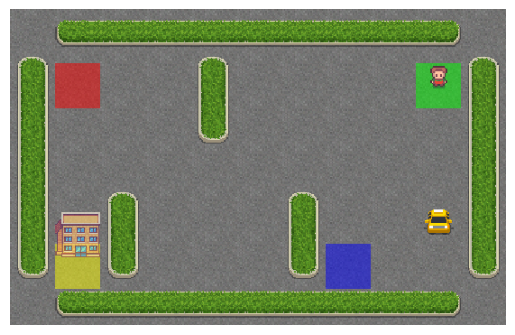

Action Space Discrete(6)
State Space Discrete(500)


In [16]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=SEED)
plt.imshow(env.render())
plt.axis("off")
plt.show()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

In [17]:
q_table = np.zeros((env.observation_space.n, env.action_space.n))

rewards = []
for episode in range(1, MAX_EPISODE+1):
    
    if episode % 1000 == 0:
        print('Evaluating Episode: ', episode)
        
    state, _ = env.reset()
    done = False
    
    episode_reward = 0
    while not done:

        # ε-greedy policy
        if np.random.uniform() < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        # Performing selected action
        new_state, reward, done, _, _ = env.step(action)

        # Q-learning update
        q_table[state][action] += ALPHA * (reward + GAMMA * np.max(q_table[new_state]) - q_table[state][action])

        episode_reward += reward
        state = new_state
        
    rewards.append(episode_reward)

Printe the q table

In [18]:
q_table[:5]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-2.10653822, -2.13619729, -2.14015975, -2.14321859, -2.12641709,
        -2.81083925],
       [-1.74973864, -1.73492507, -1.71931188, -1.8044015 , -1.67801875,
        -1.99      ],
       [-2.97964426, -2.95868094, -2.97851487, -2.93598486, -2.93703574,
        -4.55662389],
       [-2.95970343, -2.95319113, -2.93957124, -2.96440197, -3.72249824,
        -3.85515345]])

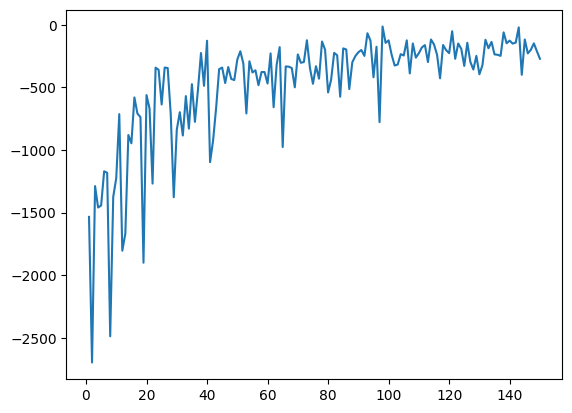

In [19]:
plt.plot(range(1, MAX_EPISODE+1), rewards)
plt.show()

In [20]:
tot_penalities = 0
tot_steps = 0
for episode in range(5):
    
    state, _ = env.reset()
    done = False
    
    steps = 0
    while not done and steps < 30:
        plt.imshow(env.render())
        plt.show()
        sleep(.1)
        clear_output(wait=True)

        # Action selection
        action = np.argmax(q_table[state])
        
        # Performing selected action
        new_state, reward, done, _, _ = env.step(action)
        
        if reward == -10:
            tot_penalities += 1
            
        tot_steps += 1
        steps += 1
        
        state = new_state

KeyboardInterrupt: 

## Deep Q-learning


In [2]:
def create_dqn_model(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs =  layers.Dense(output_shape, activation='linear')(x)

    return keras.Model(inputs=inputs, outputs=outputs)

def compute_epsilon(epsilon, eps_decay=0.995, eps_min=0.1):
  epsilon *= eps_decay
  epsilon = max(eps_min, epsilon)
  return epsilon

Lets start with the easyest envs, the cart pole

In [4]:
MAX_EPISODE = 150
MAX_STEPS = 200
GAMMA = 0.9 # Discount factor for past rewards
BATCH_SIZE = 32
REPLAY_BUFFER_LEN = 2048 # Max length of replay buffer
COPY_STEP = 50

env = gym.make("CartPole-v1")

load_weights = False
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model = create_dqn_model(input_shape=env.observation_space.shape,
                         output_shape=env.action_space.n)
target_model = create_dqn_model(input_shape=env.observation_space.shape,
                            output_shape=env.action_space.n)
loss_function = keras.losses.Huber()

if load_weights:
    model.load_weights("../checkpoints/dqn_cartpole.h5")

steps_count = 0
epsilon = 1 # linear decay epsilon to encoruge exploration in early stage
total_rewards = np.empty(MAX_EPISODE)
total_avg_rewards = np.empty(MAX_EPISODE)
replay_buffer = deque(maxlen=REPLAY_BUFFER_LEN)

for episode in range(MAX_EPISODE):
    state = np.array(env.reset()[0])
    episode_reward = 0
    
    # we only consider 200 steps length episode for faster computation
    for step in range(MAX_STEPS):
        steps_count += 1

        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action = tf.argmax(model(state_tensor, training=False)[0]).numpy()

        epsilon = compute_epsilon(epsilon)

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.array(next_state)

        episode_reward += reward
        
        replay_buffer.append((state, action, reward, next_state, done))

        state = next_state

        if len(replay_buffer) >= 128:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            
            states = np.array([experience[0] for experience in batch])
            actions = [experience[1] for experience in batch]
            rewards = [experience[2] for experience in batch]
            next_states = np.array([experience[3] for experience in batch])
            dones = tf.convert_to_tensor(
                [float(experience[4]) for experience in batch]
            )
            
            future_rewards = target_model.predict(next_states, verbose=0)
            updated_q_values = rewards + GAMMA * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values * (1 - dones) - dones

            masks = tf.one_hot(actions, 2)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(states)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        

        if steps_count % 25 == 0:
            # update the the target network with new weights
            target_model.set_weights(model.get_weights())

        if done:
            break
    
    total_rewards[episode] = episode_reward
    avg_rewards = total_rewards[max(0, episode - 25):(episode + 1)].mean()
    total_avg_rewards[episode] = avg_rewards

    print(f"Episode {episode+1}:\treward={episode_reward},\tavg_reward={avg_rewards:.1f}")
 
    if avg_rewards >= 100:
        print(f"Solved in {episode+1} episodes!")
        break

print("Weight saved!")
model.save_weights("../checkpoints/dqn_cartpole.h5")

Episode 1:	reward=12.0,	avg_reward=12.0


2023-11-26 20:12:45.941807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: the library was not initialized
2023-11-26 20:12:45.941834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:222] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-11-26 20:12:45.941852: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at matmul_op_impl.h:621 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Exception encountered when calling layer 'dense_6' (type Dense).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Attempting to perform BLAS operation using StreamExecutor without BLAS support [Op:MatMul]

Call arguments received by layer 'dense_6' (type Dense):
  • inputs=tf.Tensor(shape=(1, 4), dtype=float32)

In [21]:
model.save_weights("../checkpoints/dqn_cartpole.h5")

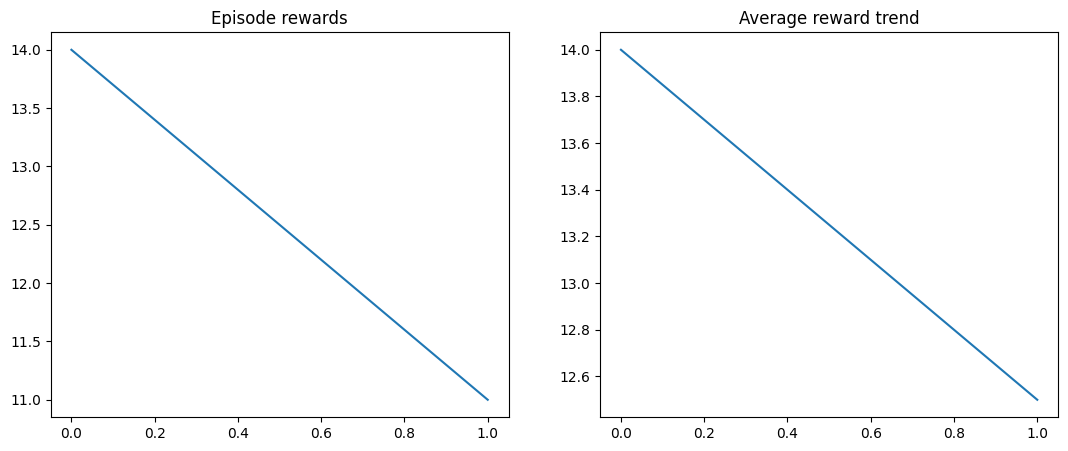

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
ax1.plot(total_rewards[:episode])
ax1.set_title("Episode rewards")
ax2.plot(total_avg_rewards[:episode])
ax2.set_title("Average reward trend")
plt.show()

Let's see how model perform after 100 episodes

In [13]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

state, _ = env.reset()
done = False
step_count = 0
max_steps = 1000
model = cart_pole_dqn_model(input_shape=env.observation_space.shape,
                            output_shape=env.action_space.n)
model.load_weights("../checkpoints/dqn_cartpole.h5")
while step_count < max_steps:
    action = np.argmax(model.predict(state.reshape(1,4), verbose=0)[0])
    step_count += 1
    next_state, reward, done, _, _ = env.step(action)
    next_state = next_state.reshape(1,4)
    state = next_state
    if done:
        print(f"End at {step_count} step")
        break
env.close()

End at 10 step
